In [1]:
import matplotlib.pyplot as plt

# 设置为刚才安装的字体
plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

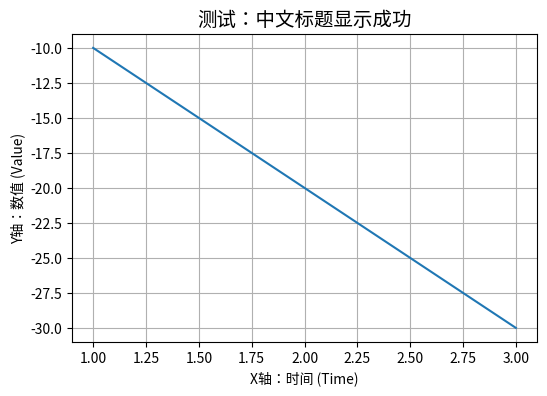

In [2]:
import matplotlib.pyplot as plt

# 1. 设置为你系统里刚刚找到的这个字体
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 

# 2. 解决负号显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False 

# --- 测试一下 ---
plt.figure(figsize=(6, 4))
plt.plot([1, 2, 3], [-10, -20, -30])
plt.title("测试：中文标题显示成功", fontsize=14)
plt.xlabel("X轴：时间 (Time)")
plt.ylabel("Y轴：数值 (Value)")
plt.grid(True)
plt.show()


参数扫描开始
图像: output/extracted_frames/low.jpg
滤波器: 巴特沃斯低通滤波器
参数范围: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

处理 D0=10...
可视化结果已保存: output/low_butterworth-lowpass_d_5/low_butterworth-lowpass_d0-10_detail.png
  已保存详细可视化: output/low_butterworth-lowpass_d_5/low_butterworth-lowpass_d0-10_detail.png
处理 D0=20...
可视化结果已保存: output/low_butterworth-lowpass_d_5/low_butterworth-lowpass_d0-20_detail.png
  已保存详细可视化: output/low_butterworth-lowpass_d_5/low_butterworth-lowpass_d0-20_detail.png
处理 D0=30...
可视化结果已保存: output/low_butterworth-lowpass_d_5/low_butterworth-lowpass_d0-30_detail.png
  已保存详细可视化: output/low_butterworth-lowpass_d_5/low_butterworth-lowpass_d0-30_detail.png
处理 D0=40...
可视化结果已保存: output/low_butterworth-lowpass_d_5/low_butterworth-lowpass_d0-40_detail.png
  已保存详细可视化: output/low_butterworth-lowpass_d_5/low_butterworth-lowpass_d0-40_detail.png
处理 D0=50...
可视化结果已保存: output/low_butterworth-lowpass_d_5/low_butterworth-lowpass_d0-50_detail.png
  已保存详细可视化: output/low_butterworth-lowpass_d_5/low

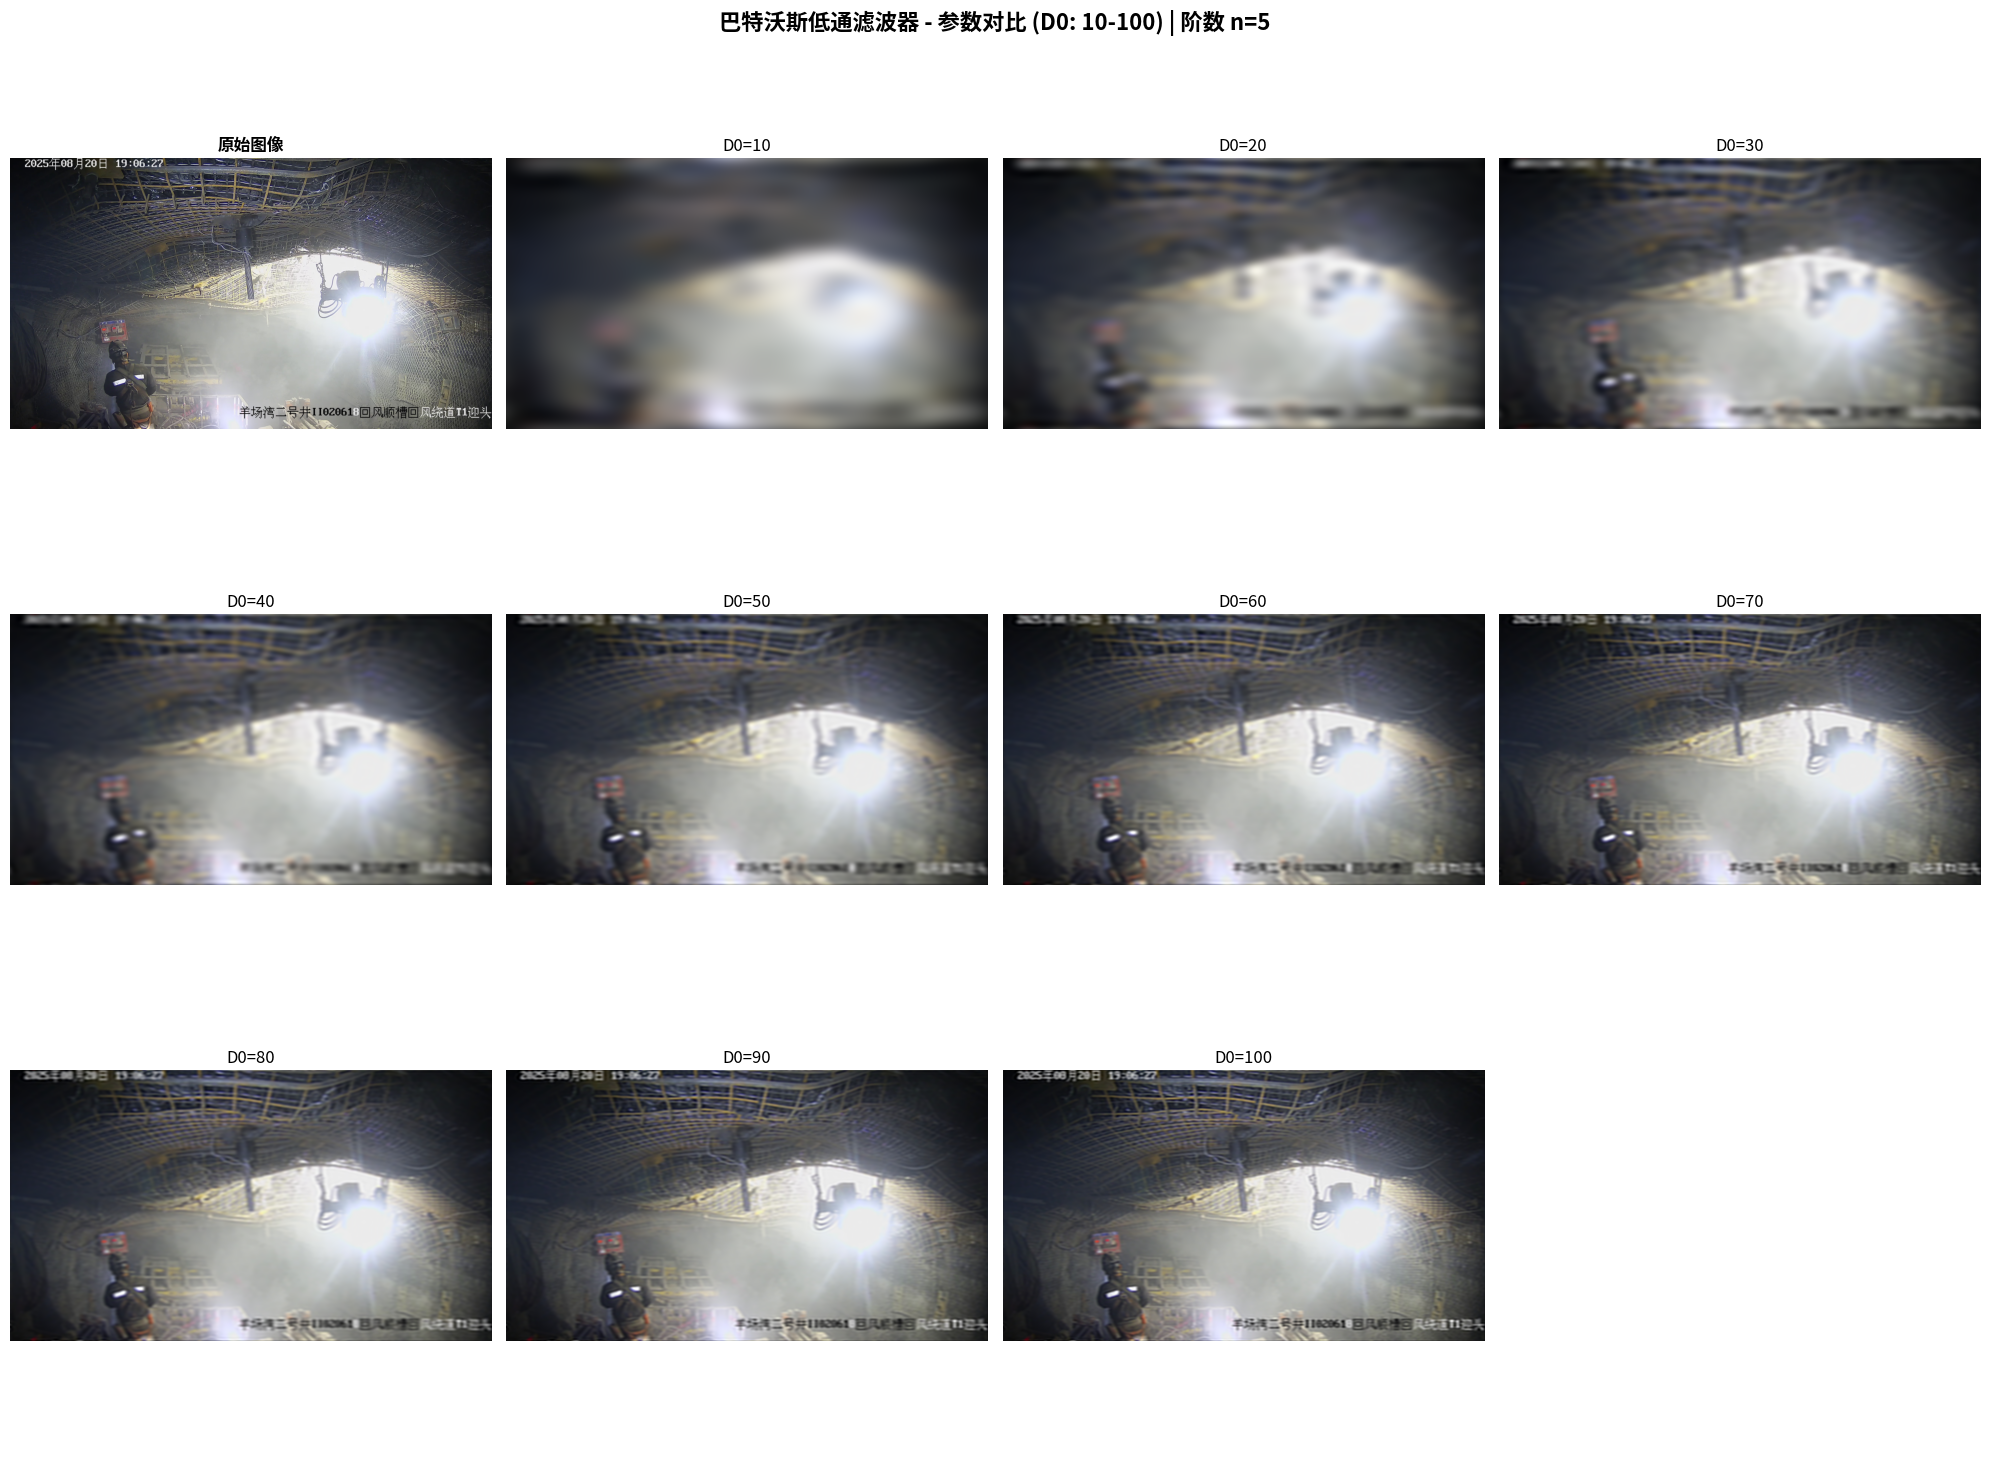


参数扫描完成！共处理 10 个参数
输出目录: output/low_butterworth-lowpass_d_5



In [45]:
#!/usr/bin/env python3
"""
图像频域滤波处理工具
使用傅里叶变换和各种滤波器对图像进行去尘处理
"""
import matplotlib.pyplot as plt

# 1. 设置为你系统里刚刚找到的这个字体
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 

# 2. 解决负号显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False 
import cv2
import numpy as np
from pathlib import Path
from typing import Tuple, List
import os
from enum import Enum
from dataclasses import dataclass




class FilterType(Enum):
    """滤波器类型枚举"""
    GAUSSIAN_LOWPASS = 'gaussian_lowpass'
    GAUSSIAN_HIGHPASS = 'gaussian_highpass'
    BUTTERWORTH_LOWPASS = 'butterworth_lowpass'
    BUTTERWORTH_HIGHPASS = 'butterworth_highpass'
    
    def get_name(self) -> str:
        """获取滤波器中文名称"""
        names = {
            FilterType.GAUSSIAN_LOWPASS: '高斯低通滤波器',
            FilterType.GAUSSIAN_HIGHPASS: '高斯高通滤波器',
            FilterType.BUTTERWORTH_LOWPASS: '巴特沃斯低通滤波器',
            FilterType.BUTTERWORTH_HIGHPASS: '巴特沃斯高通滤波器'
        }
        return names[self]
    
    def get_description(self) -> str:
        """获取滤波器描述"""
        descriptions = {
            FilterType.GAUSSIAN_LOWPASS: '保留低频，去除高频噪声',
            FilterType.GAUSSIAN_HIGHPASS: '保留高频边缘，去除低频',
            FilterType.BUTTERWORTH_LOWPASS: '平滑过渡的低通滤波',
            FilterType.BUTTERWORTH_HIGHPASS: '平滑过渡的高通滤波'
        }
        return descriptions[self]


class ProcessMode(Enum):
    """处理模式枚举"""
    SINGLE = 'single'  # 单张图像处理
    BATCH = 'batch'    # 批量处理


@dataclass
class FilterConfig:
    """
    滤波器配置类
    
    Attributes:
        input_path: 输入图像路径（单张模式）或目录路径（批量模式）
        output_dir: 输出目录
        mode: 处理模式
        filter_type: 滤波器类型（单张模式使用）
        d0: 截止频率（建议范围: 10-100）
        order: 巴特沃斯滤波器阶数（默认2）
        save_result: 是否保存处理结果到文件
        show_plot: 是否使用matplotlib显示可视化结果
        save_visualization: 是否保存可视化结果图
    """
    input_path: str
    output_dir: str = 'output/filtered'
    mode: ProcessMode = ProcessMode.SINGLE
    filter_type: FilterType = FilterType.GAUSSIAN_LOWPASS
    d0: float = 30.0
    order: int = 2
    save_result: bool = True
    show_plot: bool = True
    save_visualization: bool = True
    
    def validate(self) -> bool:
        """验证配置参数"""
        if self.d0 <= 0:
            raise ValueError(f"截止频率必须大于0，当前值: {self.d0}")
        if self.order < 1:
            raise ValueError(f"滤波器阶数必须大于等于1，当前值: {self.order}")
        return True


class FrequencyDomainFilter:
    """频域滤波器类"""
    
    def __init__(self, image_path: str):
        """
        初始化滤波器
        
        Args:
            image_path: 图像文件路径
        """
        # 读取图像（彩色）
        self.original_image = cv2.imread(image_path)
        if self.original_image is None:
            raise ValueError(f"无法读取图像: {image_path}")
        
        self.image_name = Path(image_path).stem
        
        # 判断是否为彩色图像
        if len(self.original_image.shape) == 3:
            self.is_color = True
            self.rows, self.cols, self.channels = self.original_image.shape
            # 转换为RGB（OpenCV默认是BGR）
            self.original_image_rgb = cv2.cvtColor(self.original_image, cv2.COLOR_BGR2RGB)
            # 用于显示频谱的灰度图
            gray_image = cv2.cvtColor(self.original_image, cv2.COLOR_BGR2GRAY)
        else:
            self.is_color = False
            self.rows, self.cols = self.original_image.shape
            self.channels = 1
            gray_image = self.original_image
        
        # 执行傅里叶变换（用于显示频谱）
        self.fft_image = np.fft.fft2(gray_image)
        self.fft_shifted = np.fft.fftshift(self.fft_image)
        
        # 计算幅度谱
        self.magnitude_spectrum = 20 * np.log(np.abs(self.fft_shifted) + 1)
    
    def create_gaussian_lowpass_filter(self, d0: float) -> np.ndarray:
        """
        创建高斯低通滤波器
        
        Args:
            d0: 截止频率
            
        Returns:
            滤波器掩码
        """
        center_row, center_col = self.rows // 2, self.cols // 2
        
        # 创建频率网格
        u = np.arange(self.rows)
        v = np.arange(self.cols)
        u, v = np.meshgrid(v, u)
        
        # 计算距离
        d = np.sqrt((u - center_col) ** 2 + (v - center_row) ** 2)
        
        # 高斯低通滤波器
        h = np.exp(-(d ** 2) / (2 * (d0 ** 2)))
        
        return h
    
    def create_gaussian_highpass_filter(self, d0: float) -> np.ndarray:
        """
        创建高斯高通滤波器
        
        Args:
            d0: 截止频率
            
        Returns:
            滤波器掩码
        """
        # 高通 = 1 - 低通
        return 1 - self.create_gaussian_lowpass_filter(d0)
    
    def create_butterworth_lowpass_filter(self, d0: float, n: int = 2) -> np.ndarray:
        """
        创建巴特沃斯低通滤波器
        
        Args:
            d0: 截止频率
            n: 滤波器阶数
            
        Returns:
            滤波器掩码
        """
        center_row, center_col = self.rows // 2, self.cols // 2
        
        # 创建频率网格
        u = np.arange(self.rows)
        v = np.arange(self.cols)
        u, v = np.meshgrid(v, u)
        
        # 计算距离
        d = np.sqrt((u - center_col) ** 2 + (v - center_row) ** 2)
        
        # 避免除以零
        d = np.where(d == 0, 1e-10, d)
        
        # 巴特沃斯低通滤波器
        h = 1 / (1 + (d / d0) ** (2 * n))
        
        return h
    
    def create_butterworth_highpass_filter(self, d0: float, n: int = 2) -> np.ndarray:
        """
        创建巴特沃斯高通滤波器
        
        Args:
            d0: 截止频率
            n: 滤波器阶数
            
        Returns:
            滤波器掩码
        """
        # 高通 = 1 - 低通
        return 1 - self.create_butterworth_lowpass_filter(d0, n)
    
    def apply_filter(self, filter_mask: np.ndarray) -> np.ndarray:
        """
        应用滤波器到频域图像
        
        Args:
            filter_mask: 滤波器掩码
            
        Returns:
            滤波后的图像
        """
        if self.is_color:
            # 彩色图像：分别处理RGB三个通道
            filtered_channels = []
            for i in range(3):
                channel = self.original_image[:, :, i]
                
                # 对该通道执行傅里叶变换
                fft_channel = np.fft.fft2(channel)
                fft_shifted_channel = np.fft.fftshift(fft_channel)
                
                # 在频域应用滤波器
                filtered_fft = fft_shifted_channel * filter_mask
                
                # 逆傅里叶变换
                filtered_fft_ishift = np.fft.ifftshift(filtered_fft)
                filtered_channel = np.fft.ifft2(filtered_fft_ishift)
                filtered_channel = np.abs(filtered_channel)
                
                # 归一化到0-255
                filtered_channel = np.clip(filtered_channel, 0, 255).astype(np.uint8)
                filtered_channels.append(filtered_channel)
            
            # 合并三个通道
            filtered_image = cv2.merge(filtered_channels)
        else:
            # 灰度图像：直接处理
            filtered_fft = self.fft_shifted * filter_mask
            
            # 逆傅里叶变换
            filtered_fft_ishift = np.fft.ifftshift(filtered_fft)
            filtered_image = np.fft.ifft2(filtered_fft_ishift)
            filtered_image = np.abs(filtered_image)
            
            # 归一化到0-255
            filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)
        
        return filtered_image
    
    def visualize_results(self, filter_name: str, filter_mask: np.ndarray, 
                         filtered_image: np.ndarray, save_path: str = None, show: bool = False,
                         d0: float = None, order: int = None):
        """
        可视化滤波结果
        
        Args:
            filter_name: 滤波器名称
            filter_mask: 滤波器掩码
            filtered_image: 滤波后的图像
            save_path: 保存路径（可选）
            show: 是否显示图像（默认False）
            d0: 截止频率（用于显示）
            order: 滤波器阶数（用于显示）
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 构建标题，包含参数信息
        title = f'{filter_name} - 频域滤波结果'
        if d0 is not None:
            title += f' | 截止频率 D0={d0}'
        if order is not None:
            title += f' | 阶数 n={order}'
        
        fig.suptitle(title, fontsize=16, fontweight='bold')
        
        # 原始图像
        if self.is_color:
            axes[0, 0].imshow(self.original_image_rgb)
        else:
            axes[0, 0].imshow(self.original_image, cmap='gray')
        axes[0, 0].set_title('原始图像')
        axes[0, 0].axis('off')
        
        # 频谱
        axes[0, 1].imshow(self.magnitude_spectrum, cmap='gray')
        axes[0, 1].set_title('傅里叶频谱')
        axes[0, 1].axis('off')
        
        # 滤波器掩码
        axes[0, 2].imshow(filter_mask, cmap='gray')
        axes[0, 2].set_title('滤波器掩码')
        axes[0, 2].axis('off')
        
        # 滤波后的频谱
        filtered_spectrum = 20 * np.log(np.abs(self.fft_shifted * filter_mask) + 1)
        axes[1, 0].imshow(filtered_spectrum, cmap='gray')
        axes[1, 0].set_title('滤波后的频谱')
        axes[1, 0].axis('off')
        
        # 滤波后的图像
        if self.is_color:
            # 将BGR转为RGB显示
            filtered_image_rgb = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB)
            axes[1, 1].imshow(filtered_image_rgb)
        else:
            axes[1, 1].imshow(filtered_image, cmap='gray')
        axes[1, 1].set_title('滤波后的图像')
        axes[1, 1].axis('off')
        
        # 差异图像
        difference = cv2.absdiff(self.original_image, filtered_image)
        if self.is_color:
            # 彩色差异图转为灰度显示
            difference_gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
            axes[1, 2].imshow(difference_gray, cmap='hot')
        else:
            axes[1, 2].imshow(difference, cmap='hot')
        axes[1, 2].set_title('差异图像')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"可视化结果已保存: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()


def process_single_filter(image_path: str, filter_type: FilterType, d0: float, 
                          n: int = 2, output_dir: str = "output/filtered",
                          save_result: bool = True, show_plot: bool = True, 
                          save_visualization: bool = True):
    """
    使用指定的滤波器处理图像
    
    Args:
        image_path: 输入图像路径
        filter_type: 滤波器类型（FilterType枚举）
        d0: 截止频率
        n: 巴特沃斯滤波器阶数（仅用于butterworth类型）
        output_dir: 输出目录
        save_result: 是否保存处理后的图像
        show_plot: 是否显示可视化结果
        save_visualization: 是否保存可视化结果图
    """
    # 创建输出目录
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # 初始化滤波器
    print(f"\n处理图像: {image_path}")
    processor = FrequencyDomainFilter(image_path)
    image_name = processor.image_name
    
    # 获取滤波器名称
    filter_name = filter_type.get_name()
    print(f"\n应用 {filter_name}...")
    print(f"  参数: d0={d0}" + (f", n={n}" if 'butterworth' in filter_type.value else ""))
    
    # 创建滤波器
    if filter_type == FilterType.GAUSSIAN_LOWPASS:
        filter_mask = processor.create_gaussian_lowpass_filter(d0)
    elif filter_type == FilterType.GAUSSIAN_HIGHPASS:
        filter_mask = processor.create_gaussian_highpass_filter(d0)
    elif filter_type == FilterType.BUTTERWORTH_LOWPASS:
        filter_mask = processor.create_butterworth_lowpass_filter(d0, n)
    elif filter_type == FilterType.BUTTERWORTH_HIGHPASS:
        filter_mask = processor.create_butterworth_highpass_filter(d0, n)
    else:
        raise ValueError(f"不支持的滤波器类型: {filter_type}")
    
    # 应用滤波器
    filtered_image = processor.apply_filter(filter_mask)
    
    # 准备文件路径
    filter_type_short = filter_type.value.replace('_', '-')
    output_image_path = output_path / f"{image_name}_{filter_type_short}_d0-{d0}.jpg"
    vis_path = output_path / f"{image_name}_{filter_type_short}_d0-{d0}_visualization.png"
    
    # 保存滤波后的图像
    if save_result:
        cv2.imwrite(str(output_image_path), filtered_image)
        print(f"  已保存滤波图像: {output_image_path}")
    
    # 可视化结果
    save_vis_path = str(vis_path) if save_visualization else None
    processor.visualize_results(filter_name, filter_mask, filtered_image, 
                               save_path=save_vis_path, show=show_plot,
                               d0=d0, order=n)
    
    return {
        'name': filter_name,
        'image_path': str(output_image_path) if save_result else None,
        'visualization_path': str(vis_path) if save_visualization else None
    }


def process_image_with_filters(image_path: str, output_dir: str = "output/filtered"):
    """
    使用多种滤波器处理图像（批量处理所有滤波器）
    
    Args:
        image_path: 输入图像路径
        output_dir: 输出目录
    """
    # 创建输出目录
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # 初始化滤波器
    print(f"\n处理图像: {image_path}")
    processor = FrequencyDomainFilter(image_path)
    image_name = processor.image_name
    
    # 滤波器参数配置
    # d0: 截止频率（像素）- 越小保留的低频越少
    filters_config = [
        {
            'type': FilterType.GAUSSIAN_LOWPASS,
            'd0': 30,  # 截止频率
            'n': 2
        },
        {
            'type': FilterType.GAUSSIAN_HIGHPASS,
            'd0': 30,
            'n': 2
        },
        {
            'type': FilterType.BUTTERWORTH_LOWPASS,
            'd0': 30,
            'n': 2  # 阶数
        },
        {
            'type': FilterType.BUTTERWORTH_HIGHPASS,
            'd0': 30,
            'n': 2
        }
    ]
    
    results = []
    
    for config in filters_config:
        filter_type = config['type']
        print(f"\n应用 {filter_type.get_name()}...")
        print(f"  描述: {filter_type.get_description()}")
        
        # 创建滤波器
        if filter_type == FilterType.GAUSSIAN_LOWPASS:
            filter_mask = processor.create_gaussian_lowpass_filter(config['d0'])
        elif filter_type == FilterType.GAUSSIAN_HIGHPASS:
            filter_mask = processor.create_gaussian_highpass_filter(config['d0'])
        elif filter_type == FilterType.BUTTERWORTH_LOWPASS:
            filter_mask = processor.create_butterworth_lowpass_filter(config['d0'], config['n'])
        elif filter_type == FilterType.BUTTERWORTH_HIGHPASS:
            filter_mask = processor.create_butterworth_highpass_filter(config['d0'], config['n'])
        
        # 应用滤波器
        filtered_image = processor.apply_filter(filter_mask)
        
        # 保存滤波后的图像
        filter_type_short = filter_type.value.replace('_', '-')
        output_image_path = output_path / f"{image_name}_{filter_type_short}.jpg"
        cv2.imwrite(str(output_image_path), filtered_image)
        print(f"  已保存滤波图像: {output_image_path}")
        
        # 保存可视化结果
        vis_path = output_path / f"{image_name}_{filter_type_short}_visualization.png"
        processor.visualize_results(filter_type.get_name(), filter_mask, filtered_image, 
                                   str(vis_path), show=False, 
                                   d0=config['d0'], order=config['n'])
        
        results.append({
            'name': filter_type.get_name(),
            'image_path': str(output_image_path),
            'visualization_path': str(vis_path)
        })
    
    return results


def parameter_sweep(image_path: str, filter_type: FilterType = FilterType.GAUSSIAN_LOWPASS,
                   d0_range: range = range(10, 101, 10), order: int = 2,
                   output_dir: str = "output/parameter_sweep",
                   save_results: bool = True, show_comparison: bool = True,
                   save_individual_visualizations: bool = False):
    """
    参数扫描：使用不同的截止频率处理同一图像
    
    Args:
        image_path: 输入图像路径
        filter_type: 滤波器类型
        d0_range: 截止频率范围（可迭代对象，如range(10, 101, 10)）
        order: 巴特沃斯滤波器阶数
        output_dir: 输出目录
        save_results: 是否保存每个结果图像
        show_comparison: 是否显示参数对比图
        save_individual_visualizations: 是否保存每个参数的详细可视化结果（6图对比）
    
    Returns:
        包含所有结果的列表
    """
    from pathlib import Path
    
    # 创建输出目录
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    print(f"\n{'='*60}")
    print(f"参数扫描开始")
    print(f"图像: {image_path}")
    print(f"滤波器: {filter_type.get_name()}")
    print(f"参数范围: {list(d0_range)}")
    print(f"{'='*60}\n")
    
    # 初始化滤波器
    processor = FrequencyDomainFilter(image_path)
    image_name = processor.image_name
    
    results = []
    filtered_images = []
    d0_values = []
    
    # 对每个d0值进行处理
    for d0 in d0_range:
        print(f"处理 D0={d0}...")
        
        # 创建滤波器
        if filter_type == FilterType.GAUSSIAN_LOWPASS:
            filter_mask = processor.create_gaussian_lowpass_filter(d0)
        elif filter_type == FilterType.GAUSSIAN_HIGHPASS:
            filter_mask = processor.create_gaussian_highpass_filter(d0)
        elif filter_type == FilterType.BUTTERWORTH_LOWPASS:
            filter_mask = processor.create_butterworth_lowpass_filter(d0, order)
        elif filter_type == FilterType.BUTTERWORTH_HIGHPASS:
            filter_mask = processor.create_butterworth_highpass_filter(d0, order)
        else:
            raise ValueError(f"不支持的滤波器类型: {filter_type}")
        
        # 应用滤波器
        filtered_image = processor.apply_filter(filter_mask)
        filtered_images.append(filtered_image)
        d0_values.append(d0)
        
        filter_type_short = filter_type.value.replace('_', '-')
        
        # 准备文件路径
        output_image_path = output_path / f"{image_name}_{filter_type_short}_d0-{d0}.jpg"
        vis_path = output_path / f"{image_name}_{filter_type_short}_d0-{d0}_detail.png"
        
        # 保存结果图像
        if save_results:
            cv2.imwrite(str(output_image_path), filtered_image)
            print(f"  已保存图像: {output_image_path}")
        
        # 保存详细可视化结果（6图对比）
        if save_individual_visualizations:
            processor.visualize_results(
                filter_type.get_name(), 
                filter_mask, 
                filtered_image,
                save_path=str(vis_path),
                show=False,
                d0=d0,
                order=order
            )
            print(f"  已保存详细可视化: {vis_path}")
        
        results.append({
            'd0': d0,
            'filter_type': filter_type,
            'image_path': str(output_image_path) if save_results else None,
            'visualization_path': str(vis_path) if save_individual_visualizations else None
        })
    
    # 显示对比图
    if show_comparison and filtered_images:
        visualize_parameter_comparison(
            processor, filtered_images, d0_values, 
            filter_type.get_name(), order,
            save_path=str(output_path / f"{image_name}_comparison.png")
        )
    
    print(f"\n{'='*60}")
    print(f"参数扫描完成！共处理 {len(d0_values)} 个参数")
    print(f"输出目录: {output_dir}")
    print(f"{'='*60}\n")
    
    return results


def visualize_parameter_comparison(processor: FrequencyDomainFilter, 
                                   filtered_images: list, d0_values: list,
                                   filter_name: str, order: int = None,
                                   save_path: str = None):
    """
    可视化参数对比结果
    
    Args:
        processor: 频域滤波器实例
        filtered_images: 滤波后的图像列表
        d0_values: 对应的d0值列表
        filter_name: 滤波器名称
        order: 滤波器阶数
        save_path: 保存路径
    """
    n_images = len(filtered_images)
    # 计算网格布局：原图 + 滤波结果
    n_cols = min(4, n_images + 1)
    n_rows = (n_images + 1 + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # 确保axes是二维数组
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # 构建标题
    title = f'{filter_name} - 参数对比 (D0: {d0_values[0]}-{d0_values[-1]})'
    if order is not None:
        title += f' | 阶数 n={order}'
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # 显示原始图像
    ax = axes.flat[0]
    if processor.is_color:
        ax.imshow(processor.original_image_rgb)
    else:
        ax.imshow(processor.original_image, cmap='gray')
    ax.set_title('原始图像', fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # 显示每个滤波结果
    for idx, (filtered_img, d0) in enumerate(zip(filtered_images, d0_values)):
        ax = axes.flat[idx + 1]
        if processor.is_color:
            filtered_img_rgb = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2RGB)
            ax.imshow(filtered_img_rgb)
        else:
            ax.imshow(filtered_img, cmap='gray')
        ax.set_title(f'D0={d0}', fontsize=12)
        ax.axis('off')
    
    # 隐藏多余的子图
    for idx in range(n_images + 1, n_rows * n_cols):
        axes.flat[idx].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"对比图已保存: {save_path}")
    
    plt.show()


def get_config() -> FilterConfig:
    """
    获取滤波器配置
    在这里修改参数来控制图像处理
    
    Returns:
        FilterConfig: 滤波器配置对象
    """
    # ===================== 配置区域 - 在这里修改参数 =====================
    
    config = FilterConfig(
        # 处理模式
        # ProcessMode.SINGLE: 单张图像处理，使用指定的滤波器
        # ProcessMode.BATCH: 批量处理，对所有图像应用所有滤波器
        mode=ProcessMode.SINGLE,
        
        # 输入图像路径
        # 单张模式：图像文件路径，例如 'input.jpg'
        # 批量模式：目录路径，例如 'output/extracted_frames'
        input_path='output/extracted_frames/low.jpg',
        
        # 输出目录
        output_dir='output/filtered',
        
        # --- 单张图像处理配置（仅在 mode=ProcessMode.SINGLE 时使用） ---
        # 滤波器类型，可选值:
        #   FilterType.GAUSSIAN_LOWPASS      - 高斯低通滤波器（保留低频，去除高频噪声）
        #   FilterType.GAUSSIAN_HIGHPASS     - 高斯高通滤波器（保留高频边缘，去除低频）
        #   FilterType.BUTTERWORTH_LOWPASS   - 巴特沃斯低通滤波器（平滑过渡的低通）
        #   FilterType.BUTTERWORTH_HIGHPASS  - 巴特沃斯高通滤波器（平滑过渡的高通）
        filter_type=FilterType.BUTTERWORTH_LOWPASS,
        
        # 截止频率 (建议范围: 10-100)
        # 小值(10-20): 强烈滤波，图像更模糊
        # 中值(30-50): 适度滤波，平衡去噪和细节
        # 大值(60+): 轻微滤波，保留更多细节
        d0=30.0,
        
        # 巴特沃斯滤波器阶数（仅用于 FilterType.BUTTERWORTH_* 类型）
        # 1-2: 平滑过渡
        # 3-4: 更陡峭的截止
        # 5+: 非常陡峭，接近理想滤波器
        order=2,
        
        # --- 输出控制 ---
        # 是否保存处理后的图像到文件
        save_result=False,
        
        # 是否使用matplotlib显示可视化结果（会阻塞程序直到关闭窗口）
        show_plot=True,
        
        # 是否保存可视化结果图到文件
        save_visualization=False
    )
    
    # ===================================================================
    
    # 验证配置
    config.validate()
    return config


def run_parameter_sweep_example():
    """
    运行参数扫描示例
    这是一个独立的函数，用于测试不同参数的效果
    """
    # 示例1: 高斯低通滤波器，D0从10到100，步长10
    # parameter_sweep(
    #     image_path='output/extracted_frames/high.jpg',
    #     filter_type=FilterType.GAUSSIAN_LOWPASS,
    #     d0_range=range(10, 101, 10),  # 10, 20, 30, ..., 100
    #     output_dir='output/high_gaussian-lowpass_d',
    #     save_results=False,
    #     show_comparison=True,
    #     save_individual_visualizations=True  # 保存每个参数的详细可视化结果
    # )
    
    # 示例2: 自定义参数范围
    parameter_sweep(
        image_path='output/extracted_frames/low.jpg',
        filter_type=FilterType.BUTTERWORTH_LOWPASS,
        d0_range=range(10, 101, 10),  # 自定义的参数列表
        order=5,
        output_dir='output/low_butterworth-lowpass_d_5',
        save_results=False,
        show_comparison=True,
        save_individual_visualizations=True  # 不保存详细可视化（只保存对比图）
    )


# def main():
#     """主函数"""
#     # 获取配置
#     config = get_config()
    
#     if config.mode == ProcessMode.BATCH:
#         # 批量处理模式
#         input_path = Path(config.input_path)
#         if not input_path.exists():
#             print(f"错误: 输入目录不存在: {config.input_path}")
#             return
        
#         if not input_path.is_dir():
#             print(f"错误: 批量模式需要提供目录路径")
#             return
        
#         image_files = list(input_path.glob("*.jpg")) + list(input_path.glob("*.png"))
        
#         if not image_files:
#             print(f"错误: 在 {config.input_path} 中没有找到图像文件")
#             return
        
#         print(f"找到 {len(image_files)} 个图像文件")
        
#         # 处理每个图像
#         all_results = []
#         for image_file in image_files:
#             try:
#                 results = process_image_with_filters(str(image_file), config.output_dir)
#                 all_results.extend(results)
#             except Exception as e:
#                 print(f"处理 {image_file} 时出错: {e}")
        
#         # 输出总结
#         print("\n" + "="*60)
#         print("处理完成！")
#         print(f"共处理 {len(image_files)} 个图像")
#         print(f"生成 {len(all_results)} 个滤波结果")
#         print(f"输出目录: {config.output_dir}")
#         print("="*60)
    
#     elif config.mode == ProcessMode.SINGLE:
#         # 单个图像处理模式
#         input_path = Path(config.input_path)
#         if not input_path.exists():
#             print(f"错误: 输入文件不存在: {config.input_path}")
#             return
        
#         if not input_path.is_file():
#             print(f"错误: 请提供单个图像文件路径")
#             return
        
#         try:
#             result = process_single_filter(
#                 config.input_path, 
#                 config.filter_type, 
#                 config.d0, 
#                 config.order, 
#                 config.output_dir,
#                 config.save_result,
#                 config.show_plot,
#                 config.save_visualization
#             )
            
#             print("\n" + "="*60)
#             print("处理完成！")
#             print(f"滤波器: {result['name']}")
#             if result['image_path']:
#                 print(f"输出图像: {result['image_path']}")
#             if result['visualization_path']:
#                 print(f"可视化结果: {result['visualization_path']}")
#             print("="*60)
            
#         except Exception as e:
#             print(f"处理图像时出错: {e}")
#             import traceback
#             traceback.print_exc()
    
#     else:
#         print(f"错误: 不支持的模式 '{config.mode}'，请使用 ProcessMode.SINGLE 或 ProcessMode.BATCH")


# if __name__ == "__main__":
#     # 选择运行模式
#     # 模式1: 常规处理（根据get_config配置）
#     # 模式2: 参数扫描（测试不同参数效果）
    
#     RUN_MODE = 'normal'  # 'normal' 或 'parameter_sweep'
    
#     if RUN_MODE == 'parameter_sweep':
#         # 运行参数扫描
#         run_parameter_sweep_example()
#     else:
#         # 运行常规处理
#         main()

run_parameter_sweep_example()
